
"""

Performance Variables 

- Wins 
- Places
- Win as Favs 
- Place as Favs
- Wins as Underdogs
- Place as Underdogs

"""


# Import the code 


In [1]:

#fileloc  = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-one/code/Users/karan.bhatti'
fileloc  = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-one-8c-32gb/code/Users/karan.bhatti'

import sys
print(sys.path)
print()

#sys.path.append(f'{fileloc}')

print()
#print(sys.path)


['/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-one-8c-32gb/code/Users/karan.bhatti', '/anaconda/envs/azureml_py38/lib/python38.zip', '/anaconda/envs/azureml_py38/lib/python3.8', '/anaconda/envs/azureml_py38/lib/python3.8/lib-dynload', '', '/anaconda/envs/azureml_py38/lib/python3.8/site-packages', '/anaconda/envs/azureml_py38/lib/python3.8/site-packages/azureml/_project/vendor', '/anaconda/envs/azureml_py38/lib/python3.8/site-packages/azureml/automl/core/_vendor']




In [2]:

class Data(object):
    pass

df = Data
summ = Data


In [3]:
import helpdesk as hd

In [4]:

import pandas as pd, numpy as np
from datetime import datetime


In [5]:
DEBUG = True

In [6]:

pd.set_option('display.max_rows', 50);
pd.set_option('display.max_columns', 50);
pd.set_option('display.width', 200);


In [7]:


df.ft_raw = pd.read_csv(f'{fileloc}/raw_base_2023-02-09.csv', parse_dates = True)

print(df.ft_raw.shape)
print(df.ft_raw.columns.values.tolist())



(641710, 45)
['@id_DOG', 'Place', 'DogName', 'Box', 'Rug', 'Weight', 'StartPrice', 'Handicap_DOG', 'Margin1', 'Margin2', 'PIR', 'Checks', 'Comments', 'SplitMargin', 'y_runtime', 'Prizemoney', 'RaceId', 'TrainerId', 'TrainerName', 'RaceBox', 'Rating', 'DogGrade', 'DogGOBIS', 'DogPRIZE', '@id_RACE', 'RaceNum', 'RaceName', 'RaceTime', 'Distance', 'RaceGrade', 'Track', 'date', 'Event_Dt', 'RaceTimeDateUTC', 'GOBIS', 'Hurdle', 'Handicap_RACE', 'TAB', 'GradeCode', 'racetime_fix', 'ft_sp', 'x_num_dogs', 'position', 'y_margin', 'y_pos']


In [8]:

print(pd.DataFrame(df.ft_raw.position.value_counts()).transpose())

print(pd.DataFrame(df.ft_raw.x_num_dogs.value_counts()).transpose())


              1      2      3      4      5      6      7      8
position  89096  88993  88945  88921  88880  83059  67066  46750
                 8       7      6      5
x_num_dogs  374400  142471  95814  29025


### B) Create Variable for Performance

In [9]:

df_base_perf = df.ft_raw.copy()


In [10]:

# Sort for Easy QC
df_base_perf.sort_values(by = ['@id_DOG', 'DogName', 'Event_Dt'], inplace = True)


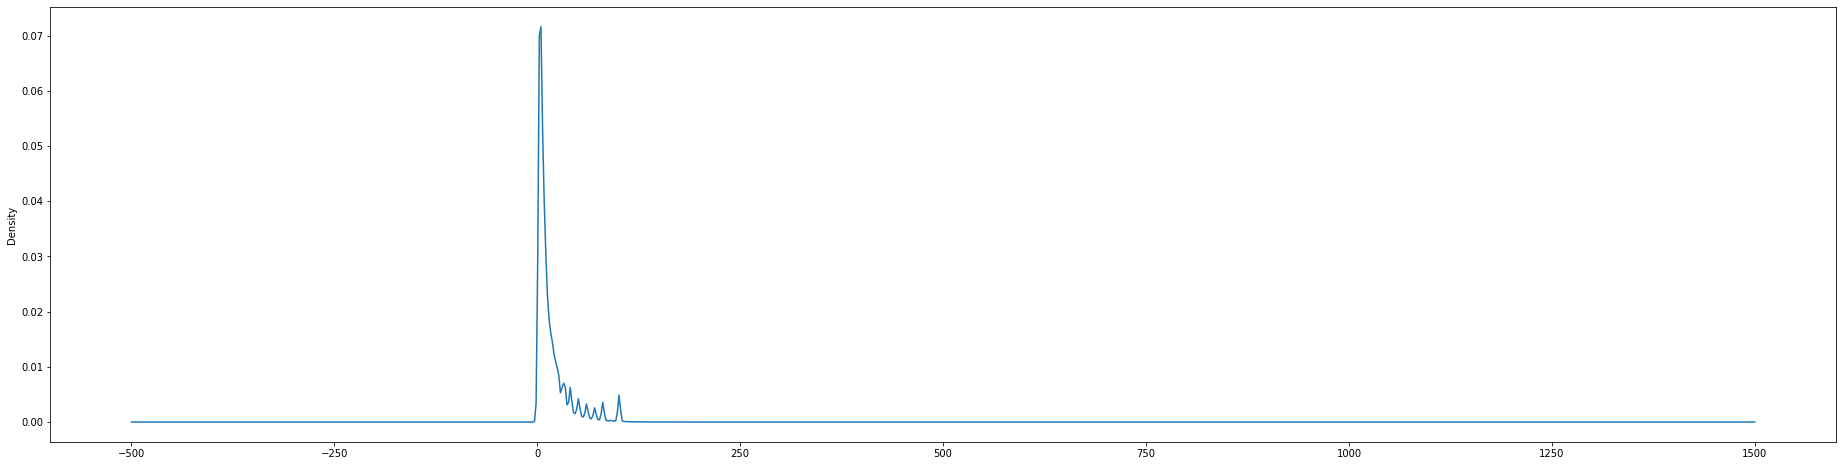

In [11]:

df_base_perf['ft_sp'].plot(kind = 'density', figsize= (32,8) )


In [12]:

# Ranks based on the Fast Track sp
groupings = ['@id_RACE']

# For groupby doglevel
doglevel = ['@id_DOG']


## Rank for Place Preds
print(datetime.now())
df_base_perf["position_fasttrack"] = df_base_perf.groupby(groupings)["ft_sp"].rank("dense", ascending=True)
print(datetime.now())


2023-02-22 20:40:45.800725
2023-02-22 20:40:45.962283


##### Wins related Performance 

In [13]:

# Total Races
df_base_perf.loc[:,"xr_races"] = df_base_perf.groupby(doglevel).cumcount()

# Total Races in last 5 
df_base_perf.loc[:,"xr_races_l5"] = df_base_perf.groupby(doglevel).rolling(5, min_periods=1)['xr_races'].count().reset_index(0,drop=True)



#Wins by a Dog
df_base_perf.loc[:,"wins"] = df_base_perf['position'].apply(lambda x : 1 if x == '1' else 0 )



# Rolling wins for each Dog
df_base_perf.loc[:,"wins_prev"] = df_base_perf.groupby(doglevel)['wins'].shift(1)

df_base_perf.loc[:,"xr_wins"] = df_base_perf.groupby(doglevel)['wins_prev'].rolling(window=999, min_periods = 1).sum().reset_index(0,drop=True)
df_base_perf['xr_wins'].fillna(0, inplace = True)

df_base_perf.loc[:,"xr_wins_pct"] = df_base_perf['xr_wins'] / df_base_perf['xr_races']
df_base_perf['xr_wins_pct'].fillna(0, inplace = True)


## Wins in the Last 5 Races
df_base_perf.loc[:,"xr_wins_l5"] = df_base_perf.groupby(doglevel)['wins_prev'].rolling(window=5, min_periods = 1).sum().reset_index(0,drop=True)
df_base_perf['xr_wins_l5'].fillna(0, inplace = True)

df_base_perf.loc[:,"xr_wins_l5_pct"] = df_base_perf['xr_wins_l5'] / df_base_perf['xr_races_l5']


print(datetime.now())

#.rolling(8, min_periods=1, on='Date')['Sold'].sum().reset_index()['Sold']


2023-02-22 20:41:30.283083


In [14]:

#df_base_perf[ df_base_perf['@id_DOG'].isin( [109766097, 113531628] ) ].head(45)
df_base_perf[135:145]


,@id_DOG,Place,DogName,Box,Rug,Weight,StartPrice,Handicap_DOG,Margin1,Margin2,PIR,Checks,Comments,SplitMargin,y_runtime,Prizemoney,RaceId,TrainerId,TrainerName,RaceBox,Rating,DogGrade,DogGOBIS,DogPRIZE,@id_RACE,...,RaceGrade,Track,date,Event_Dt,RaceTimeDateUTC,GOBIS,Hurdle,Handicap_RACE,TAB,GradeCode,racetime_fix,ft_sp,x_num_dogs,position,y_margin,y_pos,position_fasttrack,xr_races,xr_races_l5,wins,wins_prev,xr_wins,xr_wins_pct,xr_wins_l5,xr_wins_l5_pct
135,115152021,4,KING JEREMY,6.0,6,38.3,$21.00,NaN,4.25,1.29,NaN,0,NaN,4.56,17.23,0.0,638811645,289547,T Bradley,6.0,0.0,5,N,12450.0,638811645,...,Grade 5,Murray Bridge,09 Feb 21,2021-02-09,09 Feb 21 02:39AM,NaN,NaN,NaN,NaN,5,13:09:00,21.0,7,4,4.25,4,6.0,2,3.0,0,0.0,0.0,0.0,0.0,0.0
136,115152021,2,KING JEREMY,2.0,2,38.0,$4.80,NaN,1.75,1.71,NaN,0,NaN,4.54,16.95,160.0,640881752,289547,T Bradley,2.0,0.0,5,N,12450.0,640881752,...,Special Event Non Penalty,Murray Bridge,16 Feb 21,2021-02-16,16 Feb 21 02:06AM,NaN,NaN,NaN,NaN,SNP,12:36:00,4.8,5,2,1.75,2,3.0,3,4.0,0,0.0,0.0,0.0,0.0,0.0
137,115152021,6,KING JEREMY,2.0,2,37.3,$101.00,NaN,4.25,0.14,6,0,NaN,4.59,17.11,0.0,645453386,289547,T Bradley,2.0,0.0,5,N,12610.0,645453386,...,Grade 5 Heat,Murray Bridge,02 Mar 21,2021-03-02,02 Mar 21 03:14AM,NaN,NaN,NaN,NaN,5H,13:44:00,101.0,8,6,4.25,6,7.0,4,5.0,0,0.0,0.0,0.0,0.0,0.0
138,115152021,4,KING JEREMY,7.0,7,37.7,$11.00,NaN,4.25,1.14,NaN,0,NaN,4.57,17.18,105.0,647734905,289547,T Bradley,7.0,0.0,5,N,12610.0,647734905,...,Special Event Non Penalty,Murray Bridge,09 Mar 21,2021-03-09,09 Mar 21 04:27AM,NaN,NaN,NaN,NaN,SNP,14:57:00,11.0,6,4,4.25,4,4.0,5,5.0,0,0.0,0.0,0.0,0.0,0.0
139,115152021,4,KING JEREMY,1.0,1,38.3,$34.00,NaN,1.75,0.00,NaN,0,NaN,4.49,17.01,0.0,650237621,289547,T Bradley,1.0,0.0,5,N,12715.0,650237621,...,Grade 5,Murray Bridge,23 Mar 21,2021-03-23,23 Mar 21 03:42AM,NaN,NaN,NaN,NaN,5,14:12:00,34.0,8,4,1.75,4,6.0,6,5.0,0,0.0,0.0,0.0,0.0,0.0
140,115152021,4,KING JEREMY,5.0,5,37.5,$31.00,NaN,2.50,0.86,NaN,0,NaN,4.58,16.92,105.0,656343044,289547,T Bradley,5.0,0.0,5,N,12715.0,656343044,...,Restricted Win,Murray Bridge,17 Apr 21,2021-04-17,16 Apr 21 11:40PM,NaN,NaN,NaN,NaN,RW,09:10:00,31.0,6,4,2.50,4,5.0,7,5.0,0,0.0,0.0,0.0,0.0,0.0
141,115152021,3,KING JEREMY,5.0,5,37.2,$21.00,NaN,2.00,0.14,NaN,0,NaN,4.61,16.99,130.0,663047537,289547,T Bradley,5.0,0.0,5,N,12820.0,663047537,...,Restricted Win,Murray Bridge,28 Apr 21,2021-04-28,28 Apr 21 03:19AM,NaN,NaN,NaN,NaN,RW,12:49:00,21.0,8,3,2.00,3,6.0,8,5.0,0,0.0,0.0,0.0,0.0,0.0
142,115152021,3,KING JEREMY,4.0,4,36.8,$41.00,NaN,4.00,1.71,NaN,0,NaN,4.57,16.91,80.0,667670251,289547,T Bradley,4.0,0.0,5,N,12950.0,667670251,...,Grade 5,Murray Bridge,12 May 21,2021-05-12,12 May 21 03:32AM,NaN,NaN,NaN,NaN,5,13:02:00,41.0,5,3,4.00,3,4.0,9,5.0,0,0.0,0.0,0.0,0.0,0.0
143,115152021,2,KING JEREMY,8.0,8,37.0,$12.00,NaN,1.75,1.71,NaN,0,NaN,4.57,16.86,160.0,670592539,289547,T Bradley,8.0,0.0,5,N,13030.0,670592539,...,Grade 5,Murray Bridge,19 May 21,2021-05-19,19 May 21 05:17AM,NaN,NaN,NaN,NaN,5,14:47:00,12.0,6,2,1.75,2,4.0,10,5.0,0,0.0,0.0,0.0,0.0,0.0
144,115152021,2,KING JEREMY,2.0,2,38.0,$7.00,NaN,1.00,1.00,NaN,0,NaN,4.50,16.83,160.0,672986829,289547,T Bradley,2.0,0.0,5,N,13190.0,672986829,...,Grade 5,Murray Bridge,26 May 21,2021-05-26,26 May 21 04:42AM,NaN,NaN,NaN,NaN,5,14:12:00,7.0,5,2,1.00,2,2.0,11,5.0,0,0.0,0.0,0.0,0.0,0.0


In [15]:

#Top 2 Finish
#df_base_perf.loc[:,"fin_t2"] = df_base_perf['position'].apply(lambda x : 1 if x in ['1','2'] else 0 )
df_base_perf.loc[:,"fin_t2"] = df_base_perf['position'].apply(lambda x : 1 if x in [1,2] else 0 )

# Rolling wins for each Dog
df_base_perf.loc[:,"fin_t2_prev"] = df_base_perf.groupby(doglevel)['fin_t2'].shift(1)
df_base_perf.loc[:,"xr_fin_t2"] = df_base_perf.groupby(doglevel)['fin_t2_prev'].rolling(window=999, min_periods = 1).sum().reset_index(0,drop=True)

df_base_perf.loc[:,"xr_finl5_t2"] = df_base_perf.groupby(doglevel)['fin_t2_prev'].rolling(window=5, min_periods = 1).sum().reset_index(0,drop=True)

df_base_perf['xr_fin_t2'].fillna(0, inplace = True)
df_base_perf.loc[:,"xr_fin_t2_pct"] = df_base_perf['xr_fin_t2'] / df_base_perf['xr_races']
df_base_perf['xr_fin_t2_pct'].fillna(0, inplace = True)

df_base_perf['xr_finl5_t2'].fillna(0, inplace = True)
df_base_perf.loc[:,"xr_finl5_t2_pct"] = df_base_perf['xr_finl5_t2'] / df_base_perf['xr_races_l5']
df_base_perf['xr_finl5_t2_pct'].fillna(0, inplace = True)

print(datetime.now())


2023-02-22 20:41:46.874624


In [16]:

print(df_base_perf.columns.values.tolist())


['@id_DOG', 'Place', 'DogName', 'Box', 'Rug', 'Weight', 'StartPrice', 'Handicap_DOG', 'Margin1', 'Margin2', 'PIR', 'Checks', 'Comments', 'SplitMargin', 'y_runtime', 'Prizemoney', 'RaceId', 'TrainerId', 'TrainerName', 'RaceBox', 'Rating', 'DogGrade', 'DogGOBIS', 'DogPRIZE', '@id_RACE', 'RaceNum', 'RaceName', 'RaceTime', 'Distance', 'RaceGrade', 'Track', 'date', 'Event_Dt', 'RaceTimeDateUTC', 'GOBIS', 'Hurdle', 'Handicap_RACE', 'TAB', 'GradeCode', 'racetime_fix', 'ft_sp', 'x_num_dogs', 'position', 'y_margin', 'y_pos', 'position_fasttrack', 'xr_races', 'xr_races_l5', 'wins', 'wins_prev', 'xr_wins', 'xr_wins_pct', 'xr_wins_l5', 'xr_wins_l5_pct', 'fin_t2', 'fin_t2_prev', 'xr_fin_t2', 'xr_finl5_t2', 'xr_fin_t2_pct', 'xr_finl5_t2_pct']


##### Last position related performance

In [17]:

#Finish Last
#df_base_perf.loc[:,"fin_t2"] = df_base_perf['position'].apply(lambda x : 1 if x in ['1','2'] else 0 )
df_base_perf.loc[:,"fin_last"] = df_base_perf.apply(lambda x : 1 if x.position == x.x_num_dogs else 0 , axis = 1)

# Rolling wins for each Dog
df_base_perf.loc[:,"fin_last_prev"] = df_base_perf.groupby(doglevel)['fin_last'].shift(1)
df_base_perf.loc[:,"xr_fin_last"] = df_base_perf.groupby(doglevel)['fin_last_prev'].rolling(window=999, min_periods = 1).sum().reset_index(0,drop=True)

df_base_perf['xr_fin_last'].fillna(0, inplace = True)
df_base_perf.loc[:,"xr_fin_last_pct"] = df_base_perf['xr_fin_last'] / df_base_perf['xr_races']
df_base_perf['xr_fin_last_pct'].fillna(0, inplace = True)


df_base_perf.loc[:,"xr_finl5_last"] = df_base_perf.groupby(doglevel)['fin_last_prev'].rolling(window=5, min_periods = 1).sum().reset_index(0,drop=True)

df_base_perf['xr_finl5_last'].fillna(0, inplace = True)
df_base_perf.loc[:,"xr_finl5_last_pct"] = df_base_perf['xr_finl5_last'] / df_base_perf['xr_races_l5']
df_base_perf['xr_finl5_last_pct'].fillna(0, inplace = True)

print(datetime.now())


2023-02-22 20:42:11.357322


In [18]:

#Finish Last x 2
#df_base_perf.loc[:,"fin_t2"] = df_base_perf['position'].apply(lambda x : 1 if x in ['1','2'] else 0 )
df_base_perf.loc[:,"fin_last2"] = df_base_perf.apply(lambda x : 1 if (x.position == x.x_num_dogs) | (x.position == x.x_num_dogs - 1) else 0 , axis = 1)


# Rolling wins for each Dog
df_base_perf.loc[:,"fin_last2_prev"] = df_base_perf.groupby(doglevel)['fin_last2'].shift(1)
df_base_perf.loc[:,"xr_fin_last2"] = df_base_perf.groupby(doglevel)['fin_last2_prev'].rolling(window=999, min_periods = 1).sum().reset_index(0,drop=True)

df_base_perf['xr_fin_last2'].fillna(0, inplace = True)
df_base_perf.loc[:,"xr_fin_last2_pct"] = df_base_perf['xr_fin_last2'] / df_base_perf['xr_races']
df_base_perf['xr_fin_last2_pct'].fillna(0, inplace = True)


df_base_perf.loc[:,"xr_finl5_last2"] = df_base_perf.groupby(doglevel)['fin_last2_prev'].rolling(window=5, min_periods = 1).sum().reset_index(0,drop=True)

df_base_perf['xr_finl5_last2'].fillna(0, inplace = True)
df_base_perf.loc[:,"xr_finl5_last2_pct"] = df_base_perf['xr_finl5_last2'] / df_base_perf['xr_races_l5']
df_base_perf['xr_finl5_last2_pct'].fillna(0, inplace = True)

print(datetime.now())


2023-02-22 20:42:41.558430


##### Place related performance

In [19]:

#Create a Placed variable 
'''
df_base_perf.loc[:,"fin_plc"] = df_base_perf.apply(lambda x : 1 if (x.position in ['1','2','3']) & (x.x_num_dogs >=8)\
                                    else 1 if (x.position in ['1','2']) & (x.x_num_dogs >= 5)\
                                    else 0 if (x.x_num_dogs < 5)\
                                    else 0, axis = 1)
'''
    
df_base_perf.loc[:,"fin_plc"] = df_base_perf.apply(lambda x : 1 if (x.position in [1,2,3]) & (x.x_num_dogs >=8)\
                                    else 1 if (x.position in [1,2]) & (x.x_num_dogs >= 5)\
                                    else 0 if (x.x_num_dogs < 5)\
                                    else 0, axis = 1)

# Rolling wins for each Dog
df_base_perf.loc[:,"fin_plc_prev"] = df_base_perf.groupby(doglevel)['fin_plc'].shift(1)

df_base_perf.loc[:,"xr_fin_plc"] = df_base_perf.groupby(doglevel)['fin_plc_prev'].rolling(window=999, min_periods = 1).sum().reset_index(0,drop=True)

df_base_perf['xr_fin_plc'].fillna(0, inplace = True)
df_base_perf.loc[:,"xr_fin_plc_pct"] = df_base_perf['xr_fin_plc'] / df_base_perf['xr_races']
df_base_perf['xr_fin_plc_pct'].fillna(0, inplace = True)


df_base_perf.loc[:,"xr_finl5_plc"] = df_base_perf.groupby(doglevel)['fin_plc_prev'].rolling(window=5, min_periods = 1).sum().reset_index(0,drop=True)

df_base_perf['xr_finl5_plc'].fillna(0, inplace = True)
df_base_perf.loc[:,"xr_finl5_plc_pct"] = df_base_perf['xr_finl5_plc'] / df_base_perf['xr_races_l5']
df_base_perf['xr_finl5_plc_pct'].fillna(0, inplace = True)

print(datetime.now())


2023-02-22 20:43:12.525634


In [20]:

print( pd.DataFrame(df_base_perf.isna().sum() ).transpose() )


   @id_DOG  Place  DogName  Box  Rug  Weight  StartPrice  Handicap_DOG  Margin1  Margin2    PIR  Checks  Comments  SplitMargin  y_runtime  Prizemoney  RaceId  TrainerId  TrainerName  RaceBox  \
0        0      0        0    0    0       1           0        641710        0    89096  86193       0    310727       106748          0      200203       0          0            0     1861   

   Rating  DogGrade  DogGOBIS  DogPRIZE  @id_RACE  ...  xr_wins_l5_pct  fin_t2  fin_t2_prev  xr_fin_t2  xr_finl5_t2  xr_fin_t2_pct  xr_finl5_t2_pct  fin_last  fin_last_prev  xr_fin_last  \
0       0         0      1861      1861         0  ...               0       0        28191          0            0              0                0         0          28191            0   

   xr_fin_last_pct  xr_finl5_last  xr_finl5_last_pct  fin_last2  fin_last2_prev  xr_fin_last2  xr_fin_last2_pct  xr_finl5_last2  xr_finl5_last2_pct  fin_plc  fin_plc_prev  xr_fin_plc  \
0                0              0             

In [21]:

df_base_perf[25:30]


,@id_DOG,Place,DogName,Box,Rug,Weight,StartPrice,Handicap_DOG,Margin1,Margin2,PIR,Checks,Comments,SplitMargin,y_runtime,Prizemoney,RaceId,TrainerId,TrainerName,RaceBox,Rating,DogGrade,DogGOBIS,DogPRIZE,@id_RACE,...,xr_wins_l5_pct,fin_t2,fin_t2_prev,xr_fin_t2,xr_finl5_t2,xr_fin_t2_pct,xr_finl5_t2_pct,fin_last,fin_last_prev,xr_fin_last,xr_fin_last_pct,xr_finl5_last,xr_finl5_last_pct,fin_last2,fin_last2_prev,xr_fin_last2,xr_fin_last2_pct,xr_finl5_last2,xr_finl5_last2_pct,fin_plc,fin_plc_prev,xr_fin_plc,xr_fin_plc_pct,xr_finl5_plc,xr_finl5_plc_pct
25,109032188,4,DESTINI TRUCKER,6.0,6,33.9,$11.00,NaN,5.37,1.97,M/43,4,NaN,8.56,23.01,NaN,637193352,130173,R Winter,6.0,93.0,5,N,54737.0,637193352,...,0.0,0,0.0,1.0,1.0,0.333333,0.25,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,1.0,2.0,0.666667,2.0,0.5
26,109032188,6,DESTINI TRUCKER,8.0,9,33.8,$45.00,NaN,10.37,1.04,M/355,0,NaN,5.32,25.50,NaN,640627712,130173,R Winter,9.0,89.0,5,N,54737.0,640627712,...,0.0,0,0.0,1.0,1.0,0.250000,0.20,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,2.0,0.500000,2.0,0.4
27,109032188,1,DESTINI TRUCKER,1.0,1,34.1,$16.00,NaN,1.91,NaN,Q/111,0,NaN,5.27,25.15,NaN,643136707,130173,R Winter,1.0,99.0,5,N,54737.0,643136707,...,0.0,1,0.0,1.0,1.0,0.200000,0.20,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1,0.0,2.0,0.400000,2.0,0.4
28,109032188,4,DESTINI TRUCKER,2.0,2,34.4,$9.40,NaN,3.91,1.41,M/64,0,NaN,9.75,17.79,NaN,645386699,130173,R Winter,2.0,93.0,4,N,56387.0,645386699,...,0.0,0,1.0,2.0,1.0,0.333333,0.20,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,1.0,3.0,0.500000,2.0,0.4
29,109032188,2,DESTINI TRUCKER,1.0,1,34.0,$7.30,NaN,0.43,0.43,M/11,1,NaN,9.89,18.13,NaN,691658567,130173,R Winter,1.0,100.0,5,N,56387.0,691658567,...,0.0,1,0.0,2.0,1.0,0.285714,0.20,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1,0.0,3.0,0.428571,2.0,0.4


#### C) Create Performance Calculation Variables 

In [22]:

#For the Wins in RaceType for the future

"""
# ADDITIONAL VARIABLES
grouplevel = ['@id_DOG','x_dist_gp']

# GROUPED X_DIST 
df.ft['x_dist_gp'] = df.ft['x_dist'].apply(lambda x : 300 if x < 330 else 350 if x < 380 else 400 if x < 420 else 450 if x < 485 else 500 if x < 550 else 600 if x < 650 else 700 if x < 750 else -999)
df.ft['x_runtm_gp'] = ( df.ft['RunTime'] / df.ft['x_dist'] ) * df.ft['x_dist_gp']

df.ft['x_rtgp_prev'] = df.ft.groupby(grouplevel)['x_runtm_gp'].shift(1)

#df.ft['x_rtgp_avg'] = df.ft.groupby(grouplevel)['x_rtgp_prev'].rolling(window=99, min_periods = 1).mean().reset_index(drop=True)
df.ft['x_rtgp_avg'] = df.ft.groupby(grouplevel)['x_rtgp_prev'].rolling(window=99, min_periods = 1).mean().values

#df.ft['x_rtgp_min'] = df.ft.groupby(grouplevel)['x_rtgp_prev'].rolling(window=99, min_periods = 1).min().reset_index(drop=True)
df.ft['x_rtgp_min'] = df.ft.groupby(grouplevel)['x_rtgp_prev'].rolling(window=99, min_periods = 1).min().values

#df.ft['x_rtgp_max'] = df.ft.groupby(grouplevel)['x_rtgp_prev'].rolling(window=99, min_periods = 1).max().reset_index(0,drop=True)
df.ft['x_rtgp_max'] = df.ft.groupby(grouplevel)['x_rtgp_prev'].rolling(window=99, min_periods = 1).max().values

df.ft['x_rtgp_range'] = df.ft['x_rtgp_max'] - df.ft['x_rtgp_min']

#df.ft['x_rtgp_std'] = df.ft.groupby(grouplevel)['x_rtgp_prev'].rolling(window=99, min_periods = 1).std().reset_index(0,drop=True)
df.ft['x_rtgp_std'] = df.ft.groupby(grouplevel)['x_rtgp_prev'].rolling(window=99, min_periods = 1).std().values

"""

print(datetime.now())


2023-02-22 20:43:12.969521


In [23]:

print(df_base_perf.shape)
print()
print(df_base_perf.columns.values.tolist())
print()


(641710, 78)

['@id_DOG', 'Place', 'DogName', 'Box', 'Rug', 'Weight', 'StartPrice', 'Handicap_DOG', 'Margin1', 'Margin2', 'PIR', 'Checks', 'Comments', 'SplitMargin', 'y_runtime', 'Prizemoney', 'RaceId', 'TrainerId', 'TrainerName', 'RaceBox', 'Rating', 'DogGrade', 'DogGOBIS', 'DogPRIZE', '@id_RACE', 'RaceNum', 'RaceName', 'RaceTime', 'Distance', 'RaceGrade', 'Track', 'date', 'Event_Dt', 'RaceTimeDateUTC', 'GOBIS', 'Hurdle', 'Handicap_RACE', 'TAB', 'GradeCode', 'racetime_fix', 'ft_sp', 'x_num_dogs', 'position', 'y_margin', 'y_pos', 'position_fasttrack', 'xr_races', 'xr_races_l5', 'wins', 'wins_prev', 'xr_wins', 'xr_wins_pct', 'xr_wins_l5', 'xr_wins_l5_pct', 'fin_t2', 'fin_t2_prev', 'xr_fin_t2', 'xr_finl5_t2', 'xr_fin_t2_pct', 'xr_finl5_t2_pct', 'fin_last', 'fin_last_prev', 'xr_fin_last', 'xr_fin_last_pct', 'xr_finl5_last', 'xr_finl5_last_pct', 'fin_last2', 'fin_last2_prev', 'xr_fin_last2', 'xr_fin_last2_pct', 'xr_finl5_last2', 'xr_finl5_last2_pct', 'fin_plc', 'fin_plc_prev', 'xr_fin_plc'

In [24]:

print( pd.DataFrame(df_base_perf.isna().sum() ).transpose() )


   @id_DOG  Place  DogName  Box  Rug  Weight  StartPrice  Handicap_DOG  Margin1  Margin2    PIR  Checks  Comments  SplitMargin  y_runtime  Prizemoney  RaceId  TrainerId  TrainerName  RaceBox  \
0        0      0        0    0    0       1           0        641710        0    89096  86193       0    310727       106748          0      200203       0          0            0     1861   

   Rating  DogGrade  DogGOBIS  DogPRIZE  @id_RACE  ...  xr_wins_l5_pct  fin_t2  fin_t2_prev  xr_fin_t2  xr_finl5_t2  xr_fin_t2_pct  xr_finl5_t2_pct  fin_last  fin_last_prev  xr_fin_last  \
0       0         0      1861      1861         0  ...               0       0        28191          0            0              0                0         0          28191            0   

   xr_fin_last_pct  xr_finl5_last  xr_finl5_last_pct  fin_last2  fin_last2_prev  xr_fin_last2  xr_fin_last2_pct  xr_finl5_last2  xr_finl5_last2_pct  fin_plc  fin_plc_prev  xr_fin_plc  \
0                0              0             

In [25]:

#df.ft.head(25)
#df.ft[ df.ft['@id_DOG'].isin([108390981,108391383,108391431]) ].head(25)
#df.ft[ df.ft['x_runtm_gp'].isna()].head()



### Treat Missing Values


In [26]:

"""
# All Columns Realted to Average Speed

df.ft['x_no_prev_races'] = df.ft['speed_prev'].apply( lambda x : 1 if pd.isna(x) else 0)

print( df.ft['x_no_prev_races'].value_counts() )

df.ft['x_speed_prev'] = df.ft['speed_prev'].fillna(0)
df.ft['x_speed_avg'] = df.ft['speed_avg'].fillna(0)
df.ft['x_speed_min'] = df.ft['speed_min'].fillna(0)
df.ft['x_speed_max'] = df.ft['speed_max'].fillna(0)

df.ft['x_speed_range'] = df.ft['speed_range'].fillna(-1)

df.ft['x_speed_std'] = df.ft['speed_std'].fillna(0)
df.ft['x_speed_std'] = df.ft.apply(lambda x : -1 if x.x_no_prev_races == 1 else x.x_speed_std, axis = 1  )
"""

print(datetime.now())


2023-02-22 20:43:13.414615


### EXPORTING THE PERFORMANCE Dataset

In [27]:

print(df_base_perf.columns.values.tolist())


['@id_DOG', 'Place', 'DogName', 'Box', 'Rug', 'Weight', 'StartPrice', 'Handicap_DOG', 'Margin1', 'Margin2', 'PIR', 'Checks', 'Comments', 'SplitMargin', 'y_runtime', 'Prizemoney', 'RaceId', 'TrainerId', 'TrainerName', 'RaceBox', 'Rating', 'DogGrade', 'DogGOBIS', 'DogPRIZE', '@id_RACE', 'RaceNum', 'RaceName', 'RaceTime', 'Distance', 'RaceGrade', 'Track', 'date', 'Event_Dt', 'RaceTimeDateUTC', 'GOBIS', 'Hurdle', 'Handicap_RACE', 'TAB', 'GradeCode', 'racetime_fix', 'ft_sp', 'x_num_dogs', 'position', 'y_margin', 'y_pos', 'position_fasttrack', 'xr_races', 'xr_races_l5', 'wins', 'wins_prev', 'xr_wins', 'xr_wins_pct', 'xr_wins_l5', 'xr_wins_l5_pct', 'fin_t2', 'fin_t2_prev', 'xr_fin_t2', 'xr_finl5_t2', 'xr_fin_t2_pct', 'xr_finl5_t2_pct', 'fin_last', 'fin_last_prev', 'xr_fin_last', 'xr_fin_last_pct', 'xr_finl5_last', 'xr_finl5_last_pct', 'fin_last2', 'fin_last2_prev', 'xr_fin_last2', 'xr_fin_last2_pct', 'xr_finl5_last2', 'xr_finl5_last2_pct', 'fin_plc', 'fin_plc_prev', 'xr_fin_plc', 'xr_fin_plc_

In [29]:

# 'TrainerName', 'Track' have been dummified
cols_for_drop = [ 'Box','Rug','Weight'\
                 #'Handicap'
                ,'Margin1','Margin2','PIR','Checks','Comments','SplitMargin','Prizemoney','RaceId','TrainerId','RaceTime','Distance','RaceGrade','date'\
                , 'Place','StartPrice'\
                , 'DogName', 'TrainerName', 'RaceNum', 'RaceName', 'Track', 'Event_Dt', 'position','y_runtime'\
                ,'ft_sp', 'x_num_dogs'\
                , 'wins' ,'wins_prev'
                , 'fin_t2' ,'fin_t2_prev' ,'fin_plc' ,'fin_plc_prev'\
                , 'fin_last', 'fin_last_prev', 'fin_last2', 'fin_last2_prev'\
                , 'y_margin', 'y_pos' ,'position_fasttrack']

## SHOULD BE THE LAST STEP OR a Separate Code
#df_base_perf1 = df_base_perf.copy()
exp_ds = df_base_perf.drop(columns = cols_for_drop)

# removed the Categorical columns from the original datast, adds the dummy variables, creates a new dataset
print(exp_ds.columns.values.tolist())


['@id_DOG', 'Handicap_DOG', 'RaceBox', 'Rating', 'DogGrade', 'DogGOBIS', 'DogPRIZE', '@id_RACE', 'RaceTimeDateUTC', 'GOBIS', 'Hurdle', 'Handicap_RACE', 'TAB', 'GradeCode', 'racetime_fix', 'xr_races', 'xr_races_l5', 'xr_wins', 'xr_wins_pct', 'xr_wins_l5', 'xr_wins_l5_pct', 'xr_fin_t2', 'xr_finl5_t2', 'xr_fin_t2_pct', 'xr_finl5_t2_pct', 'xr_fin_last', 'xr_fin_last_pct', 'xr_finl5_last', 'xr_finl5_last_pct', 'xr_fin_last2', 'xr_fin_last2_pct', 'xr_finl5_last2', 'xr_finl5_last2_pct', 'xr_fin_plc', 'xr_fin_plc_pct', 'xr_finl5_plc', 'xr_finl5_plc_pct']


In [30]:

exp_ds.head(11)


,@id_DOG,Handicap_DOG,RaceBox,Rating,DogGrade,DogGOBIS,DogPRIZE,@id_RACE,RaceTimeDateUTC,GOBIS,Hurdle,Handicap_RACE,TAB,GradeCode,racetime_fix,xr_races,xr_races_l5,xr_wins,xr_wins_pct,xr_wins_l5,xr_wins_l5_pct,xr_fin_t2,xr_finl5_t2,xr_fin_t2_pct,xr_finl5_t2_pct,xr_fin_last,xr_fin_last_pct,xr_finl5_last,xr_finl5_last_pct,xr_fin_last2,xr_fin_last2_pct,xr_finl5_last2,xr_finl5_last2_pct,xr_fin_plc,xr_fin_plc_pct,xr_finl5_plc,xr_finl5_plc_pct
0,108390981,NaN,5.0,97.0,4,N,32060.0,626271182,05 Jan 21 04:14AM,NaN,NaN,NaN,NaN,X45,15:14:00,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.00
1,108390981,NaN,4.0,95.0,5,N,32140.0,629797242,12 Jan 21 04:09AM,NaN,NaN,NaN,NaN,5,15:09:00,1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.00
2,108390981,NaN,5.0,90.0,5,N,32140.0,629797513,19 Jan 21 02:27AM,NaN,NaN,NaN,NaN,5,13:27:00,2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.00
3,108390981,NaN,1.0,96.0,4,N,34030.0,638810808,16 Feb 21 03:42AM,NaN,NaN,NaN,NaN,X45H,14:42:00,3,4.0,0.0,0.0,0.0,0.0,1.0,1.0,0.333333,0.25,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,1.0,0.333333,1.0,0.25
4,108390981,NaN,8.0,85.0,4,N,34030.0,643554706,02 Mar 21 03:22AM,NaN,NaN,NaN,NaN,4,14:22:00,4,5.0,0.0,0.0,0.0,0.0,1.0,1.0,0.250000,0.20,0.0,0.0,0.0,0.0,1.0,0.250000,1.0,0.20,1.0,0.250000,1.0,0.20
5,108391383,NaN,6.0,92.0,5,N,8539.0,626218628,04 Jan 21 10:52AM,NaN,NaN,NaN,NaN,6,18:52:00,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.00
6,108391383,NaN,5.0,93.0,5,N,8539.0,629829667,07 Jan 21 11:04AM,NaN,NaN,NaN,NaN,6,19:04:00,1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.00
7,108391383,NaN,8.0,76.0,5,N,8539.0,629829905,13 Jan 21 12:32PM,NaN,NaN,NaN,NaN,6,20:32:00,2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.00
8,108391383,NaN,2.0,76.0,5,N,8539.0,629797520,17 Jan 21 08:14AM,NaN,NaN,NaN,NaN,6,16:14:00,3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,1.0,0.333333,1.0,0.25,0.0,0.000000,0.0,0.00
9,108391383,NaN,7.0,81.0,5,N,8589.0,643552772,28 Feb 21 09:47AM,NaN,NaN,NaN,NaN,6,17:47:00,4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,1.0,0.250000,1.0,0.20,0.0,0.000000,0.0,0.00


In [31]:

todaydt = datetime.now().date()
exp_fname = f'dataprep_performance_{todaydt}.csv'


In [32]:
print(exp_ds.shape)

(641710, 37)


In [33]:

print(exp_ds.columns.values.tolist())


['@id_DOG', 'Handicap_DOG', 'RaceBox', 'Rating', 'DogGrade', 'DogGOBIS', 'DogPRIZE', '@id_RACE', 'RaceTimeDateUTC', 'GOBIS', 'Hurdle', 'Handicap_RACE', 'TAB', 'GradeCode', 'racetime_fix', 'xr_races', 'xr_races_l5', 'xr_wins', 'xr_wins_pct', 'xr_wins_l5', 'xr_wins_l5_pct', 'xr_fin_t2', 'xr_finl5_t2', 'xr_fin_t2_pct', 'xr_finl5_t2_pct', 'xr_fin_last', 'xr_fin_last_pct', 'xr_finl5_last', 'xr_finl5_last_pct', 'xr_fin_last2', 'xr_fin_last2_pct', 'xr_finl5_last2', 'xr_finl5_last2_pct', 'xr_fin_plc', 'xr_fin_plc_pct', 'xr_finl5_plc', 'xr_finl5_plc_pct']


In [34]:

exp_ds.head()


,@id_DOG,Handicap_DOG,RaceBox,Rating,DogGrade,DogGOBIS,DogPRIZE,@id_RACE,RaceTimeDateUTC,GOBIS,Hurdle,Handicap_RACE,TAB,GradeCode,racetime_fix,xr_races,xr_races_l5,xr_wins,xr_wins_pct,xr_wins_l5,xr_wins_l5_pct,xr_fin_t2,xr_finl5_t2,xr_fin_t2_pct,xr_finl5_t2_pct,xr_fin_last,xr_fin_last_pct,xr_finl5_last,xr_finl5_last_pct,xr_fin_last2,xr_fin_last2_pct,xr_finl5_last2,xr_finl5_last2_pct,xr_fin_plc,xr_fin_plc_pct,xr_finl5_plc,xr_finl5_plc_pct
0,108390981,NaN,5.0,97.0,4,N,32060.0,626271182,05 Jan 21 04:14AM,NaN,NaN,NaN,NaN,X45,15:14:00,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.00
1,108390981,NaN,4.0,95.0,5,N,32140.0,629797242,12 Jan 21 04:09AM,NaN,NaN,NaN,NaN,5,15:09:00,1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.00
2,108390981,NaN,5.0,90.0,5,N,32140.0,629797513,19 Jan 21 02:27AM,NaN,NaN,NaN,NaN,5,13:27:00,2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.00
3,108390981,NaN,1.0,96.0,4,N,34030.0,638810808,16 Feb 21 03:42AM,NaN,NaN,NaN,NaN,X45H,14:42:00,3,4.0,0.0,0.0,0.0,0.0,1.0,1.0,0.333333,0.25,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1.0,0.333333,1.0,0.25
4,108390981,NaN,8.0,85.0,4,N,34030.0,643554706,02 Mar 21 03:22AM,NaN,NaN,NaN,NaN,4,14:22:00,4,5.0,0.0,0.0,0.0,0.0,1.0,1.0,0.250000,0.20,0.0,0.0,0.0,0.0,1.0,0.25,1.0,0.2,1.0,0.250000,1.0,0.20


In [35]:

exp_ds.describe()


,@id_DOG,Handicap_DOG,RaceBox,Rating,DogPRIZE,@id_RACE,GOBIS,Hurdle,Handicap_RACE,xr_races,xr_races_l5,xr_wins,xr_wins_pct,xr_wins_l5,xr_wins_l5_pct,xr_fin_t2,xr_finl5_t2,xr_fin_t2_pct,xr_finl5_t2_pct,xr_fin_last,xr_fin_last_pct,xr_finl5_last,xr_finl5_last_pct,xr_fin_last2,xr_fin_last2_pct,xr_finl5_last2,xr_finl5_last2_pct,xr_fin_plc,xr_fin_plc_pct,xr_finl5_plc,xr_finl5_plc_pct
count,6.417100e+05,0.0,639849.000000,641710.000000,6.398490e+05,6.417100e+05,0.0,0.0,0.0,641710.000000,641710.000000,641710.0,641710.0,641710.0,641710.0,641710.000000,641710.000000,641710.000000,641710.000000,641710.000000,641710.000000,641710.000000,641710.000000,641710.000000,641710.000000,641710.000000,641710.000000,641710.000000,641710.000000,641710.000000,641710.000000
mean,4.716331e+08,NaN,4.585473,81.945313,1.393480e+04,7.486843e+08,NaN,NaN,NaN,19.056468,4.580966,0.0,0.0,0.0,0.0,5.791392,1.266250,0.295859,0.261879,2.172759,0.114154,0.548497,0.113871,4.622523,0.237088,1.136763,0.235483,7.270223,0.368083,1.596886,0.329952
std,1.172652e+08,NaN,2.432556,28.141374,2.566634e+04,6.927769e+07,NaN,NaN,NaN,16.772309,1.049205,0.0,0.0,0.0,0.0,5.918552,1.165497,0.216101,0.237099,2.760366,0.146463,0.799155,0.165697,5.056783,0.201623,1.119076,0.228603,7.143048,0.233260,1.275624,0.257448
min,1.083910e+08,NaN,1.000000,0.000000,0.000000e+00,6.238619e+08,NaN,NaN,NaN,0.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.077278e+08,NaN,2.000000,84.000000,2.670000e+03,6.892971e+08,NaN,NaN,NaN,6.000000,5.000000,0.0,0.0,0.0,0.0,1.000000,0.000000,0.147059,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.097561,0.000000,0.000000,2.000000,0.222222,1.000000,0.200000
50%,4.654220e+08,NaN,4.000000,91.000000,7.698000e+03,7.506544e+08,NaN,NaN,NaN,15.000000,5.000000,0.0,0.0,0.0,0.0,4.000000,1.000000,0.280000,0.200000,1.000000,0.078947,0.000000,0.000000,3.000000,0.210526,1.000000,0.200000,5.000000,0.363636,1.000000,0.400000
75%,5.504112e+08,NaN,7.000000,96.000000,1.672500e+04,8.077565e+08,NaN,NaN,NaN,28.000000,5.000000,0.0,0.0,0.0,0.0,8.000000,2.000000,0.416667,0.400000,3.000000,0.166667,1.000000,0.200000,7.000000,0.333333,2.000000,0.400000,11.000000,0.500000,2.000000,0.500000
max,2.145360e+09,NaN,10.000000,100.000000,2.259370e+06,8.686263e+08,NaN,NaN,NaN,131.000000,5.000000,0.0,0.0,0.0,0.0,56.000000,5.000000,1.000000,1.000000,50.000000,1.000000,5.000000,1.000000,71.000000,1.000000,5.000000,1.000000,63.000000,1.000000,5.000000,1.000000


In [36]:

print(pd.DataFrame(exp_ds.isna().sum()).transpose())


   @id_DOG  Handicap_DOG  RaceBox  Rating  DogGrade  DogGOBIS  DogPRIZE  @id_RACE  RaceTimeDateUTC   GOBIS  Hurdle  Handicap_RACE     TAB  GradeCode  racetime_fix  xr_races  xr_races_l5  xr_wins  \
0        0        641710     1861       0         0      1861      1861         0            41207  641710  641710         641710  445100          0         41207         0            0        0   

   xr_wins_pct  xr_wins_l5  xr_wins_l5_pct  xr_fin_t2  xr_finl5_t2  xr_fin_t2_pct  xr_finl5_t2_pct  xr_fin_last  xr_fin_last_pct  xr_finl5_last  xr_finl5_last_pct  xr_fin_last2  xr_fin_last2_pct  \
0            0           0               0          0            0              0                0            0                0              0                  0             0                 0   

   xr_finl5_last2  xr_finl5_last2_pct  xr_fin_plc  xr_fin_plc_pct  xr_finl5_plc  xr_finl5_plc_pct  
0               0                   0           0               0             0                 0  


In [37]:

exp_ds.to_csv(f'{fileloc}/{exp_fname}', index = False)


In [38]:

print(datetime.now())
print()
print('THE END')


2023-02-22 21:41:54.023366

THE END


In [39]:
print()